# Take Home Assignment (Unit 27)
#### Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

In [1]:
# import lib

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


from collections import Counter
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics

# utils
from sklearn.model_selection import train_test_split


In [2]:
basedir="/Users/yuenyeelo/Documents/springboard/projects/Unit27/ultimate_challenge/"
login_file=basedir+"logins.json"
data_file=basedir+"ultimate_data_challenge.json"

df_login=pd.read_json(login_file)
df_data=pd.read_json(data_file)

# Part 1 : EDA
##### The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [3]:
df_login['login_time']=pd.to_datetime(df_login['login_time'])
print(df_login.columns)
print(df_login.shape)
print("Start date:" , df_login['login_time'].min())
print("End date:  ", df_login['login_time'].max())
print(df_login.info())

Index(['login_time'], dtype='object')
(93142, 1)
Start date: 1970-01-01 20:12:16
End date:   1970-04-13 18:57:38
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


In [4]:
df_login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


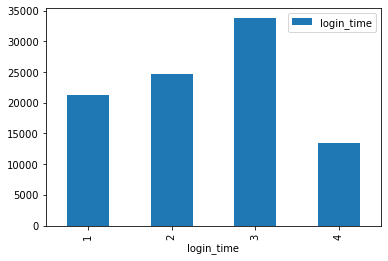

In [5]:
df_login.groupby(df_login["login_time"].dt.month).count().plot(kind="bar")

In [6]:
df_login_grouped=df_login.groupby(['login_time',df_login.login_time.dt.floor('15Min')]).size().to_frame()
df_login_grouped.head()

,,0
login_time,login_time,
1970-01-01 20:12:16,1970-01-01 20:00:00,1
1970-01-01 20:13:18,1970-01-01 20:00:00,1
1970-01-01 20:16:10,1970-01-01 20:15:00,1
1970-01-01 20:16:36,1970-01-01 20:15:00,1
1970-01-01 20:16:37,1970-01-01 20:15:00,1


In [7]:
print(df_login_grouped.columns)
df_login_grouped.head()
#df_login_grouped.

RangeIndex(start=0, stop=1, step=1)


,,0
login_time,login_time,
1970-01-01 20:12:16,1970-01-01 20:00:00,1
1970-01-01 20:13:18,1970-01-01 20:00:00,1
1970-01-01 20:16:10,1970-01-01 20:15:00,1
1970-01-01 20:16:36,1970-01-01 20:15:00,1
1970-01-01 20:16:37,1970-01-01 20:15:00,1


In [8]:
#df_login_grouped['login_time'].value_counts()

In [9]:
df_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [10]:
df_data.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [11]:
df_data['signup_date']=pd.to_datetime(df_data['signup_date'])
df_data['last_trip_date']=pd.to_datetime(df_data['last_trip_date'])
df_data.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [12]:
# check if there is nan

df_data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [13]:
# replace nan with mean
df_data['avg_rating_of_driver'].fillna(value=df_data['avg_rating_of_driver'].mean(), inplace=True)
df_data['avg_rating_by_driver'].fillna(value=df_data['avg_rating_by_driver'].mean(), inplace=True)

# replace phone type by unknown
df_data['phone'].fillna(value="unknown", inplace=True)
df_data.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [14]:
df_data['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

# Part 2 ‐ Experiment and metrics design
##### The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. 

#### 1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

#### In Gotham, active at night while at Metropolis active during the day, drivers can do both cities with different timing. Morevoer, the company will reimburse all toll costs.

#### 2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: 

##### a) how you will implement the experiment.
#### We can random select a set of drivers, one set serve both cities, one set serve only one of the cities. It is like A/B test. We can set a time period of 3 months. And compare the results if there is statiscial signitificant. 

##### b) what statistical test(s) you will conduct to verify the significance of the observation 

#####  1) State the Research Hypothesis
##### 2) State the Null Hypothesis
##### 3) Select a probability of error level (alpha level)
##### 4) Select and compute the test for statistical significance
##### 5) Interpret the results
 
 
##### c) how you would interpret the results and provide recommendations to the city operations team along with any caveats. 

##### Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.

# Part 3 ‐ Predictive modeling 

##### Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 


##### We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

## what factors are the best predictors for retention

In [15]:
# catagories data to number
df_data["ultimate_black_user"].replace({False: 0, True: 1}, inplace=True)
# df_data["phone"].replace({"iPhone": 0, "Android": 1, "unknown" :2}, inplace=True)
#Winterfell        23336
#Astapor           16534
#King's Landing    10130

# df_data["city"].replace({"Winterfell": 0, "Astapor": 1, "King's Landing" :2}, inplace=True)


df_data = pd.get_dummies(df_data, columns = ['city', 'phone'])

In [85]:
df_data.dtypes

city                               int64
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                              int64
surge_pct                        float64
ultimate_black_user                int64
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
class                              int64
dtype: object

### It is a classification problem, if user retain, we set to 1, otherwise 0

##### A user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

In [86]:
# last trip day last_trip_date

print(df_data["signup_date"].max())
print(df_data["signup_date"].min())


print(df_data["last_trip_date"].max())
print(df_data["last_trip_date"].min())


2014-01-31 00:00:00
2014-01-01 00:00:00
2014-07-01 00:00:00
2014-01-01 00:00:00


In [99]:
df_data["signup_date_year"]=df_data["signup_date"].dt.year
df_data["signup_date_month"]=df_data["signup_date"].dt.month
df_data["signup_date_day"]=df_data["signup_date"].dt.day

In [100]:

df_data['class']=0
#adopt_users = df[df.freq >= 3]['user_id'].unique()
retained=df_data[(df_data["last_trip_date"] > np.datetime64('2014-06-01'))]
print(retained.shape)

df_data.loc[(df_data["last_trip_date"] > np.datetime64('2014-06-01')), 'class']=1
df_data['class'].value_counts()

(18310, 16)


0    31690
1    18310
Name: class, dtype: int64

## The retained rate is 36.6%

In [101]:
df_cleaned=df_data

In [102]:
retained.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,class,signup_date_year,signup_date_month,signup_date_day
0,2,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,1,46.2,3.67,5.0,0,2014,1,25
3,2,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,1,80.0,2.36,4.9,0,2014,1,10
5,0,2,2014-01-09,3.5,1.00,2014-06-06,0,0.0,1,100.0,10.56,5.0,0,2014,1,9
13,2,0,2014-01-29,4.0,1.38,2014-06-08,0,50.0,0,50.0,3.04,5.0,0,2014,1,29
16,2,1,2014-01-11,5.0,1.00,2014-06-28,1,0.0,1,50.0,10.86,3.0,0,2014,1,11


In [103]:
df_cleaned.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,class,signup_date_year,signup_date_month,signup_date_day
0,2,4,2014-01-25,4.7,1.10,2014-06-17,0,15.4,1,46.2,3.67,5.0,1,2014,1,25
1,1,0,2014-01-29,5.0,1.00,2014-05-05,1,0.0,0,50.0,8.26,5.0,0,2014,1,29
2,1,3,2014-01-06,4.3,1.00,2014-01-07,0,0.0,0,100.0,0.77,5.0,0,2014,1,6
3,2,9,2014-01-10,4.6,1.14,2014-06-29,0,20.0,1,80.0,2.36,4.9,1,2014,1,10
4,0,14,2014-01-27,4.4,1.19,2014-03-15,1,11.8,0,82.4,3.13,4.9,0,2014,1,27


In [140]:
# split data for training and testing
X=df_cleaned.drop(['last_trip_date','signup_date','class'],axis=1)
y=df_cleaned['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [141]:
X_train.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_date_year,signup_date_month,signup_date_day
38094,1,1,5.000000,1.00,1,0.0,0,0.0,23.84,5.0,2014,1,18
40624,1,1,4.601559,1.00,0,0.0,1,0.0,7.74,5.0,2014,1,4
49425,1,1,5.000000,1.00,1,0.0,0,0.0,4.51,5.0,2014,1,4
35734,0,5,4.800000,1.23,0,14.3,0,28.6,2.02,4.6,2014,1,3
41708,2,7,4.900000,1.00,0,0.0,1,70.6,3.15,4.9,2014,1,17


In [142]:
print(X_train.shape)
print(X_test.shape)

(35000, 13)
(15000, 13)


In [143]:


# baseline logistic regression
def run_LR(X_train,y_train, X_test, y_test):
    LR = LogisticRegression()
    LR.fit(X_train,y_train)
    sc_train=LR.score(X_train, y_train, sample_weight=None)
    sc_test=LR.score(X_test, y_test, sample_weight=None)
    
    #print(sc_train, sc_test)
    y_pred=LR.predict(X_test)
    #print(y_test.shape)
    #print(y_pred.shape)
    print(confusion_matrix(y_test, y_pred))
    f1=f1_score(y_test, y_pred, average='macro')
    print("F1 score: ", f1)
    print('accuracy:', LR.score( X_test, y_test))
    return LR

In [144]:
LR=run_LR(X_train,y_train, X_test, y_test)

[[8975  548]
 [4402 1075]]
F1 score:  0.543329848084138
accuracy: 0.67


/Users/yuenyeelo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [145]:
def run_RFC(X_train,y_train, X_test, y_test):
    regr = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=20,criterion='gini', class_weight='balanced')
    regr.fit(X_train, y_train)
    sc_train=regr.score(X_train, y_train, sample_weight=None)
    sc_test=regr.score(X_test, y_test, sample_weight=None)
    #print("Score_training data " , sc_train) 
    #print("Score_testing data " , sc_test)
    
    y_pred=regr.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    f1=f1_score(y_test, y_pred, average='macro')
    print("F1 score: ", f1)
    print('accuracy:', regr.score( X_test, y_test))
    

    return regr

In [146]:
regr=run_RFC(X_train,y_train, X_test, y_test)

[[7262 2261]
 [1452 4025]]
F1 score:  0.7403760738924516
accuracy: 0.7524666666666666


In [147]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return fi_df

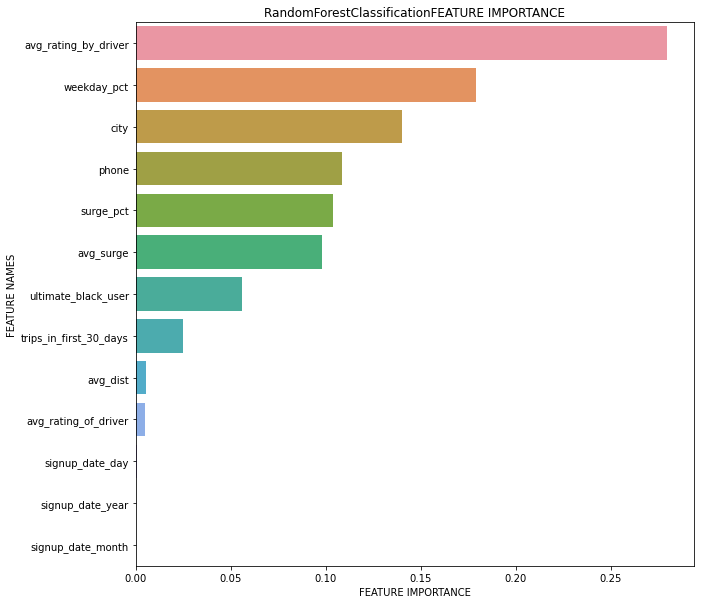

In [148]:
importances = regr.feature_importances_
features=X.columns
features_df=plot_feature_importance(importances,features,'RandomForestClassification')

In [149]:
# GradientBoostingClassifier
def run_GBC(X_train,y_train, X_test, y_test):
    params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.05}
    GBC = GradientBoostingClassifier(**params)
    GBC.fit(X_train, y_train)
    sc_train=GBC.score(X_train, y_train, sample_weight=None)
    sc_test=GBC.score(X_test, y_test, sample_weight=None)
    
    print("Score_training data " , sc_train) 
    print("Score_testing data " , sc_test)
    y_pred=GBC.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    f1=f1_score(y_test, y_pred, average='macro')
    print("F1 score: ", f1)
    print('accuracy:', GBC.score( X_test, y_test))
    
    return GBC

In [150]:
GBR=run_GBC(X_train,y_train, X_test, y_test)

Score_training data  0.7943714285714286
Score_testing data  0.7874
[[8194 1329]
 [1860 3617]]
F1 score:  0.7655733941234741
accuracy: 0.7874


In [151]:
## 
# feature importance
print(GBR.feature_importances_)

[0.18805698 0.03467451 0.00961889 0.00347421 0.09471983 0.189239
 0.06995291 0.13273086 0.01758842 0.25843472 0.         0.
 0.00150967]


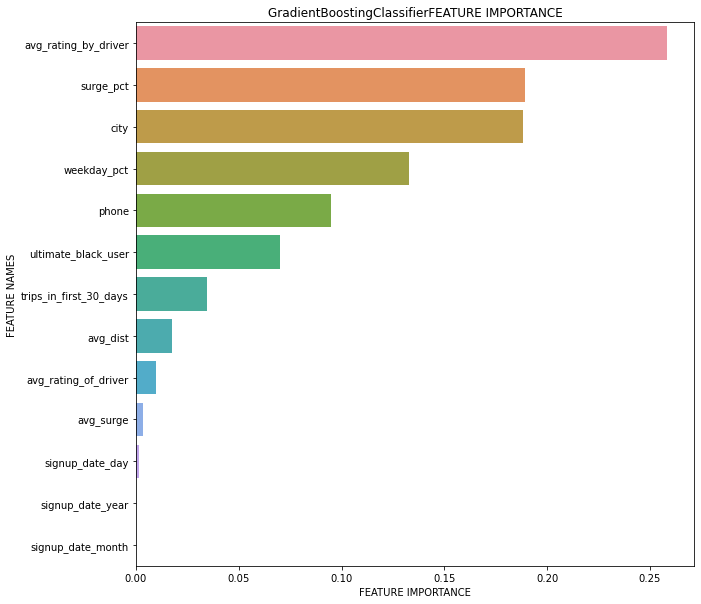

In [152]:
importances = GBR.feature_importances_
features=X.columns
features_df=plot_feature_importance(importances,features,'GradientBoostingClassifier')

### The GradientBoostingClassifier performs better than the logistic regression and RandomForrest, with F1 score 0.77 and accuracy 78%.

### Features importance: avg_rating_by_driver, city, , surge_pct, weekday_pct
